# This notebook aims to calculate as acuratly as possible the expected return:

In [42]:
# Here are the imports that we will need throughout the all notebook

import pandas as pd
import numpy as np
import os
import time
import matplotlib as plt
import sklearn
from ibapi.client import EClient
from ibapi.wrapper import EWrapper
import threading
from ib_insync import *
import asyncio
import scipy
from mpl_toolkits.mplot3d import Axes3D
import random
import statsmodels.api as sm
import statsmodels.formula.api as smf
import seaborn as sns
import matplotlib.pyplot as plt

# auto reload to reload functions imported that have been changed (cf. test_functions.sphereL1 for lbda)
%load_ext autoreload
%autoreload 2
%matplotlib widget

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
ib = IB()
util.startLoop()
await ib.connectAsync('127.0.0.1', 7497, clientId=4) # Don't forget to change the client ID

Error 321, reqId -1: Error validating request.-'ct' : cause - The API interface is currently in Read-Only mode.
Error 321, reqId -1: Error validating request.-'b3' : cause - The API interface is currently in Read-Only mode.
open orders request timed out
completed orders request timed out


<IB connected to 127.0.0.1:7497 clientId=4>

In [3]:
P = {"TTE": {"exchange": "SMART", "currency": "EUR", "primary": "SBF"},
     'AIR': {"exchange": "SMART", "currency": "EUR", "primary": "SBF"},
     'EXA': {"exchange": "SMART", "currency": "EUR", "primary": "SBF"},
     'MC': {"exchange": "SMART", "currency": "EUR", "primary": "SBF"},
     'ORA': {"exchange": "SMART", "currency": "EUR", "primary": "SBF"},
     'GLE': {"exchange": "SMART", "currency": "EUR", "primary": "SBF"},
     'ORCL': {"exchange": "SMART", "currency": "USD", "primary": "NASDAQ"},
     'BA': {"exchange": "SMART", "currency": "USD", "primary": "NASDAQ"},
     'COST': {"exchange": "SMART", "currency": "USD", "primary": "NASDAQ"},
     'NVDA': {"exchange": "SMART", "currency": "USD", "primary": "NASDAQ"},
     'WMT': {"exchange": "SMART", "currency": "USD", "primary": "NASDAQ"}
    }


In [4]:
async def fetch_stock_df(
    ib,
    symbol,
    exchange,
    currency,
    primaryExchange,
    duration='10 Y',
    barSize='1 day'
):
    contract = Stock(
        symbol=symbol,
        exchange=exchange,
        currency=currency,
        primaryExchange=primaryExchange
    )

    await ib.qualifyContractsAsync(contract)

    bars = await ib.reqHistoricalDataAsync(
        contract,
        endDateTime='',
        durationStr=duration,
        barSizeSetting=barSize,
        whatToShow='TRADES',
        useRTH=True
    )

    df = util.df(bars)
    df = df.set_index('date')[['close']]
    df.rename(columns={'close': symbol}, inplace=True)

    return df

async def fetch_one_symbol(ib, symbol, cfg):
    try:
        return await fetch_stock_df(
            ib=ib,
            symbol=symbol,
            exchange=cfg.get("exchange", "SMART"),
            currency=cfg.get("currency", "USD"),
            primaryExchange=cfg.get("primary", None)
        )
    except Exception as e:
        print(f"Error fetching {symbol}: {e}")
        return None

async def fetch_portfolio_prices(ib, P):
    tasks = [
        fetch_one_symbol(ib, symbol, cfg)
        for symbol, cfg in P.items()
    ]

    dfs = await asyncio.gather(*tasks)

    dfs = [df for df in dfs if df is not None and not df.empty]

    if not dfs:
        raise ValueError("No data retrieved")

    prices = pd.concat(dfs, axis=1, join="inner")
    prices.sort_index(inplace=True)

    return prices

In [5]:
prices = await fetch_portfolio_prices(ib, P)


In [6]:
prices

TTE      AIR    EXA      MC     ORA     GLE    ORCL      BA  \
date                                                                         
2015-12-21  41.000   62.360  17.24  143.80  15.156  42.900   36.42  140.90   
2015-12-22  41.190   61.770  17.25  143.85  15.110  42.580   36.59  142.38   
2015-12-23  42.094   62.855  17.36  146.50  15.470  43.345   36.93  144.06   
2015-12-24  42.106   62.150  17.61  146.05  15.356  43.265   37.01  143.53   
2015-12-28  41.350   61.750  17.83  144.20  15.330  42.685   36.79  144.54   
...            ...      ...    ...     ...     ...     ...     ...     ...   
2025-12-10  55.870  193.700  87.35  618.05  13.666  63.300  223.01  198.72   
2025-12-11  55.830  192.840  86.60  625.70  13.740  64.350  198.85  200.71   
2025-12-12  55.720  194.340  87.10  625.70  13.660  63.910  189.97  204.38   
2025-12-15  55.585  196.140  87.00  627.30  13.896  64.510  184.92  205.50   
2025-12-16  54.650  193.040  84.10  637.70  13.736  64.380  187.42  207.48   

              COST    NVDA     WMT  
date                                
2015-12-21  159.39    0.82   19.85  
2015-12-22  161.23    0.82   20.18  
2015-12-23  161.71    0.83   20.36  
2015-12-24  161.75    0.83   20.28  
2015-12-28  161.16    0.83   20.25  
...            ...     ...     ...  
2025-12-10  874.41  183.78  113.18  
2025-12-11  884.48  180.93  115.52  
2025-12-12  884.47  175.02  116.70  
2025-12-15  860.56  176.29  116.79  
2025-12-16  853.43  176.72  115.88  

[2486 rows x 11 columns]

## Let's now try to estimate mu:

First let's  have clear assumptions:

* We will consider a portfolio which is P
* The univers considered is liquid stocks
* Mu represent 1-week expected return
* Data frequency daily
* Let's consider log-returns
* Let's define mu as excess return ( the return without the risk free return)


In [23]:
daily_returns = np.log(prices / prices.shift(1))
daily_returns= daily_returns.dropna(how = "all") # This line drops the first line where we can't calculate the log returns

In [24]:
daily_returns

TTE       AIR       EXA        MC       ORA       GLE  \
date                                                                     
2015-12-22  0.004623 -0.009506  0.000580  0.000348 -0.003040 -0.007487   
2015-12-23  0.021710  0.017413  0.006357  0.018254  0.023546  0.017807   
2015-12-24  0.000285 -0.011280  0.014298 -0.003076 -0.007396 -0.001847   
2015-12-28 -0.018118 -0.006457  0.012416 -0.012748 -0.001695 -0.013496   
2015-12-29  0.015978  0.019406  0.001121  0.021949  0.017203  0.012109   
...              ...       ...       ...       ...       ...       ...   
2025-12-10 -0.012628 -0.009250 -0.028775  0.002836 -0.002923  0.006339   
2025-12-11 -0.000716 -0.004450 -0.008623  0.012302  0.005400  0.016452   
2025-12-12 -0.001972  0.007748  0.005757  0.000000 -0.005839 -0.006861   
2025-12-15 -0.002426  0.009219 -0.001149  0.002554  0.017129  0.009344   
2025-12-16 -0.016964 -0.015931 -0.033902  0.016443 -0.011581 -0.002017   

                ORCL        BA      COST      NVDA       WMT  
date                                                          
2015-12-22  0.004657  0.010449  0.011478  0.000000  0.016488  
2015-12-23  0.009249  0.011730  0.002973  0.012121  0.008880  
2015-12-24  0.002164 -0.003686  0.000247  0.000000 -0.003937  
2015-12-28 -0.005962  0.007012 -0.003654  0.000000 -0.001480  
2015-12-29  0.006772  0.019254  0.009264  0.011976  0.014219  
...              ...       ...       ...       ...       ...  
2025-12-10  0.006659 -0.008269 -0.015918 -0.006454 -0.016735  
2025-12-11 -0.114666  0.009964  0.011451 -0.015629  0.020464  
2025-12-12 -0.045685  0.018120 -0.000011 -0.033210  0.010163  
2025-12-15 -0.026943  0.005465 -0.027405  0.007230  0.000771  
2025-12-16  0.013429  0.009589 -0.008320  0.002436 -0.007822  

[2485 rows x 11 columns]

In [26]:
daily_returns.describe().T[["mean", "std", "min", "max"]]


mean       std       min       max
TTE   0.000116  0.017106 -0.163869  0.134713
AIR   0.000455  0.022284 -0.267063  0.190787
EXA   0.000638  0.025264 -0.211162  0.167659
MC    0.000599  0.017489 -0.076961  0.119339
ORA  -0.000040  0.012532 -0.102285  0.111541
GLE   0.000163  0.024320 -0.229023  0.163107
ORCL  0.000659  0.020410 -0.148394  0.307108
BA    0.000156  0.026356 -0.272444  0.217678
COST  0.000675  0.013920 -0.132975  0.094941
NVDA  0.002162  0.031352 -0.207943  0.263729
WMT   0.000710  0.013667 -0.120773  0.110545

Let's now consider the weekly returns, because we want to have mu of the next week:

In [28]:
weekly_returns = daily_returns.rolling(window=5).sum()
weekly_returns = weekly_returns.dropna(how = "all")

In [29]:
weekly_returns

TTE       AIR       EXA        MC       ORA       GLE  \
date                                                                     
2015-12-29  0.024478  0.009576  0.034771  0.024727  0.028618  0.007084   
2015-12-30  0.009664  0.015741  0.057995  0.025057  0.031658  0.007021   
2015-12-31 -0.019866 -0.013696  0.055461 -0.010982  0.001034 -0.018042   
2016-01-04 -0.037408 -0.025834  0.030754 -0.049835 -0.011528 -0.048178   
2016-01-05 -0.033043  0.001295 -0.010147 -0.037447 -0.002351 -0.024186   
...              ...       ...       ...       ...       ...       ...   
2025-12-10 -0.021601 -0.020238  0.058338 -0.020182 -0.026999  0.048885   
2025-12-11 -0.026425 -0.022358  0.047290 -0.011915 -0.021314  0.030451   
2025-12-12 -0.012307 -0.012985  0.059119 -0.001278 -0.007003  0.037464   
2025-12-15 -0.011359 -0.009842 -0.018224  0.008163  0.014205  0.031974   
2025-12-16 -0.034706 -0.012663 -0.066691  0.034134  0.002186  0.023257   

                ORCL        BA      COST      NVDA       WMT  
date                                                          
2015-12-29  0.016880  0.044760  0.020308  0.024098  0.034170  
2015-12-30  0.008978  0.027911  0.009138  0.012121  0.018655  
2015-12-31 -0.010890  0.003672 -0.001299 -0.012121  0.003432  
2016-01-04 -0.034638 -0.021337 -0.013757 -0.024391  0.010302  
2016-01-05 -0.031757 -0.024300 -0.007661 -0.012121  0.034938  
...              ...       ...       ...       ...       ...  
2025-12-10  0.070977 -0.019041 -0.053278  0.023063 -0.010809  
2025-12-11 -0.074966 -0.005763 -0.012784 -0.013450  0.005904  
2025-12-12 -0.135700  0.012258 -0.011478 -0.041357  0.013718  
2025-12-15 -0.176156 -0.003740 -0.030848 -0.051194  0.028046  
2025-12-16 -0.167206  0.034869 -0.040204 -0.045627  0.006841  

[2481 rows x 11 columns]

In [30]:
weekly_returns.describe().T[["mean", "std", "min", "max"]].head()

mean       std       min       max
TTE  0.000585  0.040093 -0.385438  0.429569
AIR  0.002293  0.049315 -0.559616  0.332475
EXA  0.003224  0.057904 -0.282104  0.255404
MC   0.002952  0.038006 -0.203125  0.228778
ORA -0.000215  0.028777 -0.250692  0.183461

Let's now define the zero risk rate return:

In [35]:
rf_weekly = pd.Series(0.0, index=weekly_returns.index)
excess_returns_weekly = weekly_returns.sub(rf_weekly, axis=0)
excess_returns_weekly

TTE       AIR       EXA        MC       ORA       GLE  \
date                                                                     
2015-12-29  0.024478  0.009576  0.034771  0.024727  0.028618  0.007084   
2015-12-30  0.009664  0.015741  0.057995  0.025057  0.031658  0.007021   
2015-12-31 -0.019866 -0.013696  0.055461 -0.010982  0.001034 -0.018042   
2016-01-04 -0.037408 -0.025834  0.030754 -0.049835 -0.011528 -0.048178   
2016-01-05 -0.033043  0.001295 -0.010147 -0.037447 -0.002351 -0.024186   
...              ...       ...       ...       ...       ...       ...   
2025-12-10 -0.021601 -0.020238  0.058338 -0.020182 -0.026999  0.048885   
2025-12-11 -0.026425 -0.022358  0.047290 -0.011915 -0.021314  0.030451   
2025-12-12 -0.012307 -0.012985  0.059119 -0.001278 -0.007003  0.037464   
2025-12-15 -0.011359 -0.009842 -0.018224  0.008163  0.014205  0.031974   
2025-12-16 -0.034706 -0.012663 -0.066691  0.034134  0.002186  0.023257   

                ORCL        BA      COST      NVDA       WMT  
date                                                          
2015-12-29  0.016880  0.044760  0.020308  0.024098  0.034170  
2015-12-30  0.008978  0.027911  0.009138  0.012121  0.018655  
2015-12-31 -0.010890  0.003672 -0.001299 -0.012121  0.003432  
2016-01-04 -0.034638 -0.021337 -0.013757 -0.024391  0.010302  
2016-01-05 -0.031757 -0.024300 -0.007661 -0.012121  0.034938  
...              ...       ...       ...       ...       ...  
2025-12-10  0.070977 -0.019041 -0.053278  0.023063 -0.010809  
2025-12-11 -0.074966 -0.005763 -0.012784 -0.013450  0.005904  
2025-12-12 -0.135700  0.012258 -0.011478 -0.041357  0.013718  
2025-12-15 -0.176156 -0.003740 -0.030848 -0.051194  0.028046  
2025-12-16 -0.167206  0.034869 -0.040204 -0.045627  0.006841  

[2481 rows x 11 columns]

Let's now calculate the historical mu:

In [47]:
mu_hist = excess_returns_weekly.mean(axis=0)

mu_hist.sort_values(ascending=False)

NVDA    0.010834
WMT     0.003517
COST    0.003403
ORCL    0.003377
EXA     0.003224
MC      0.002952
AIR     0.002293
GLE     0.000806
BA      0.000708
TTE     0.000585
ORA    -0.000215
dtype: float64

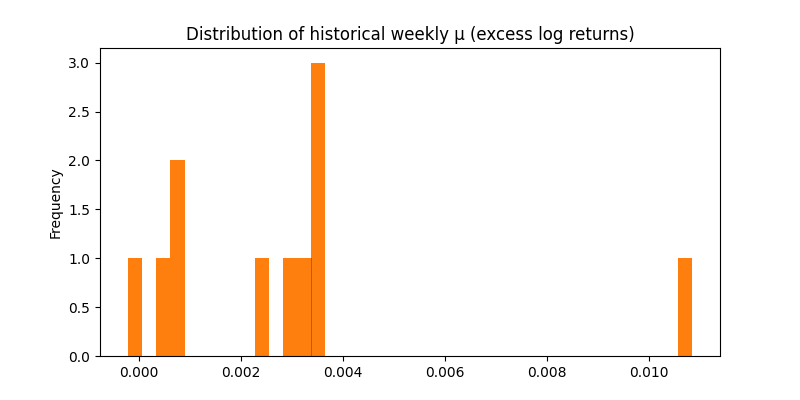

In [46]:
mu_hist.plot(kind="hist", bins=2481, figsize=(8,4))
plt.show()


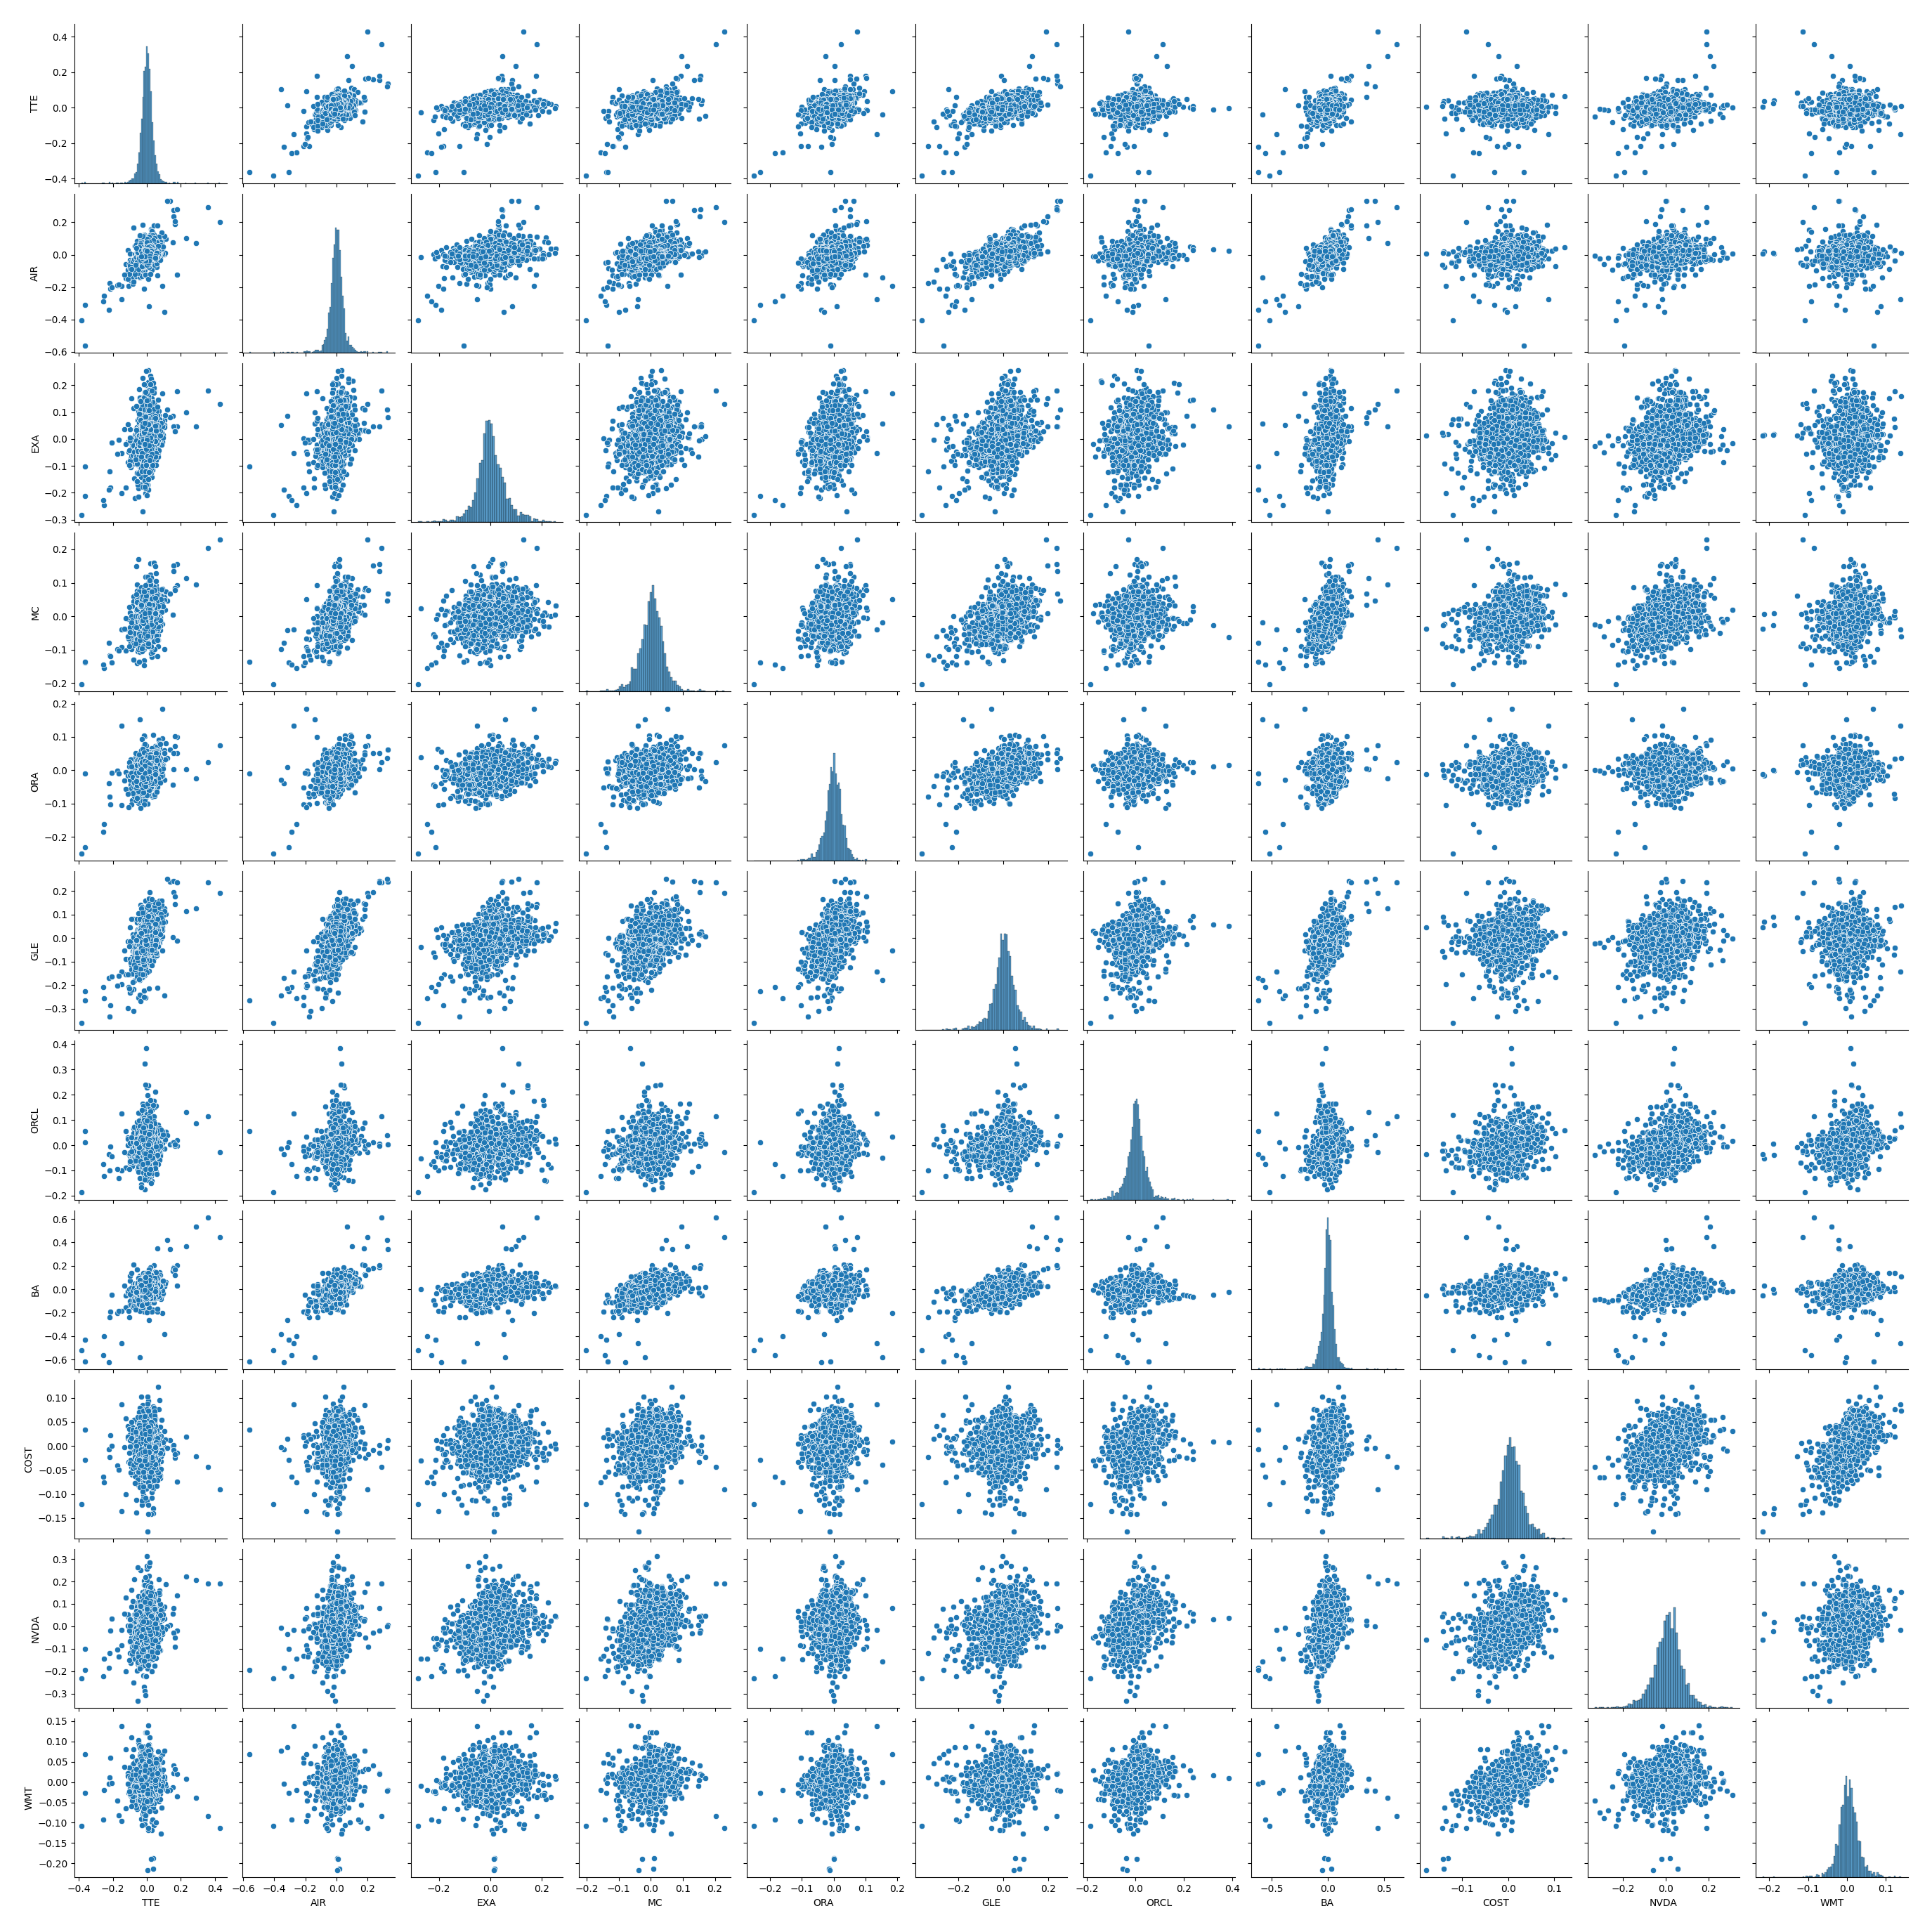

In [51]:
sns.pairplot(excess_returns_weekly)

Let's have a look on the stability of mu over the year:

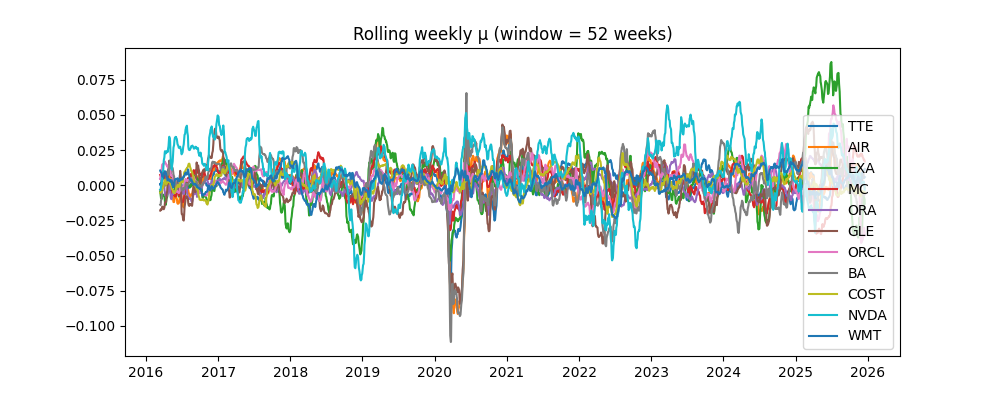

In [53]:
W = 52
mu_rolling = excess_returns_weekly.rolling(W).mean()
cols = list(mu_rolling.columns[:len(P)])

plt.figure(figsize=(10, 4))
for c in cols:
    plt.plot(mu_rolling.index, mu_rolling[c], label=c)
plt.title(f"Rolling weekly μ (window = {W} weeks)")
plt.legend()
plt.show()

In [54]:
T = excess_returns_weekly.shape[0]

mu_hist = excess_returns_weekly.mean(axis=0)
sigma_weekly = excess_returns_weekly.std(axis=0, ddof=1)

se_mu = sigma_weekly / np.sqrt(T)

# t-stat = mu / SE
t_stat = mu_hist / se_mu

t_stat.describe()


count    11.000000
mean      3.119887
std       2.681638
min      -0.371616
25%       0.714176
50%       2.772940
75%       4.805017
max       8.049554
dtype: float64

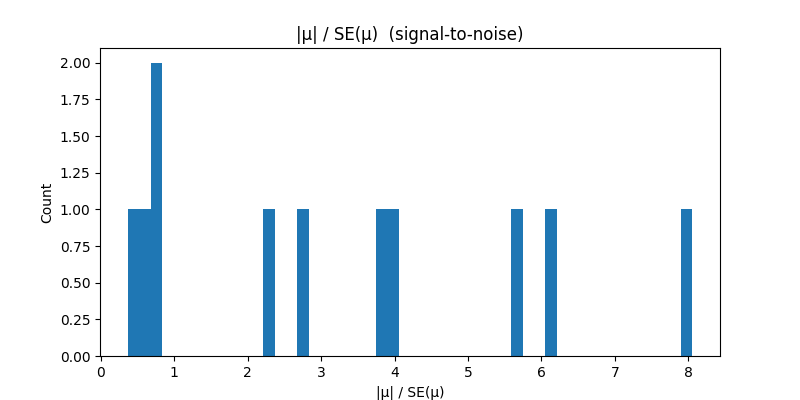

In [56]:
ratio = (mu_hist.abs() / se_mu).replace([np.inf, -np.inf], np.nan).dropna()

plt.figure(figsize=(8,4))
plt.hist(ratio, bins=50)
plt.title("|μ| / SE(μ)  (signal-to-noise)")
plt.xlabel("|μ| / SE(μ)")
plt.ylabel("Count")
plt.show()
